In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Nucleation_Dynamics as nd
import scienceplots

In [2]:
plt.style.use(['science', 'ieee'])

In [3]:
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

cluster_physics = nd.ClusterPhysics(params)

In [8]:
MAX_NUMBER_MOLECULES = 100
number_clusters_start = 2
dt = 1e-8/cluster_physics.unbiased_jump_rate.magnitude
dt = dt*1e4

In [9]:
#time_step_array = [int(1e5), int(2e5), int(3e5), int(4e5), int(5e5)]
time_step_array = [int(1e3),int(5e3), int(1e4),int(5e4)]

x_array = []
y_array = []
for ts in time_step_array:
    sim = nd.ClusterDynamics(params,ts,dt, number_clusters_start, MAX_NUMBER_MOLECULES)
    sim.simulate()
    x = sim.number_molecules_array
    y = sim.cluster_array
    x_array.append(x)
    y_array.append(y)

Computation time: 0.0073 seconds
Computation time: 0.0166 seconds
Computation time: 0.0368 seconds
Computation time: 0.1854 seconds


In [6]:
#With Numba 
""" 
# Ejemplo de uso de la clase
params = {
    'temperature': 750,
    'activation_energy': 59920.2,
    'diffusivity_factor': 2e-9,
    'jump_distance': 4.6e-10,
    'molar_mass': 150.05,
    'mass_density': 2.5,
    'melting_point': 1300,
    'heat_fusion': 52 * 1e3,
    'supersaturation_ratio': 20.5,
    'sigma': 0.15, 
    'method': 'melting'
}

Computation time: 1.4030 seconds
Computation time: 0.0169 seconds
Computation time: 0.1812 seconds
Computation time: 0.8422 seconds
 """
 # Without Numba
""" 
Computation time: 0.0014 seconds
Computation time: 0.0812 seconds
Computation time: 0.8159 seconds
Computation time: 4.1370 seconds 
"""

' \nComputation time: 0.0014 seconds\nComputation time: 0.0812 seconds\nComputation time: 0.8159 seconds\nComputation time: 4.1370 seconds \n'

(-50.0, -20.0)

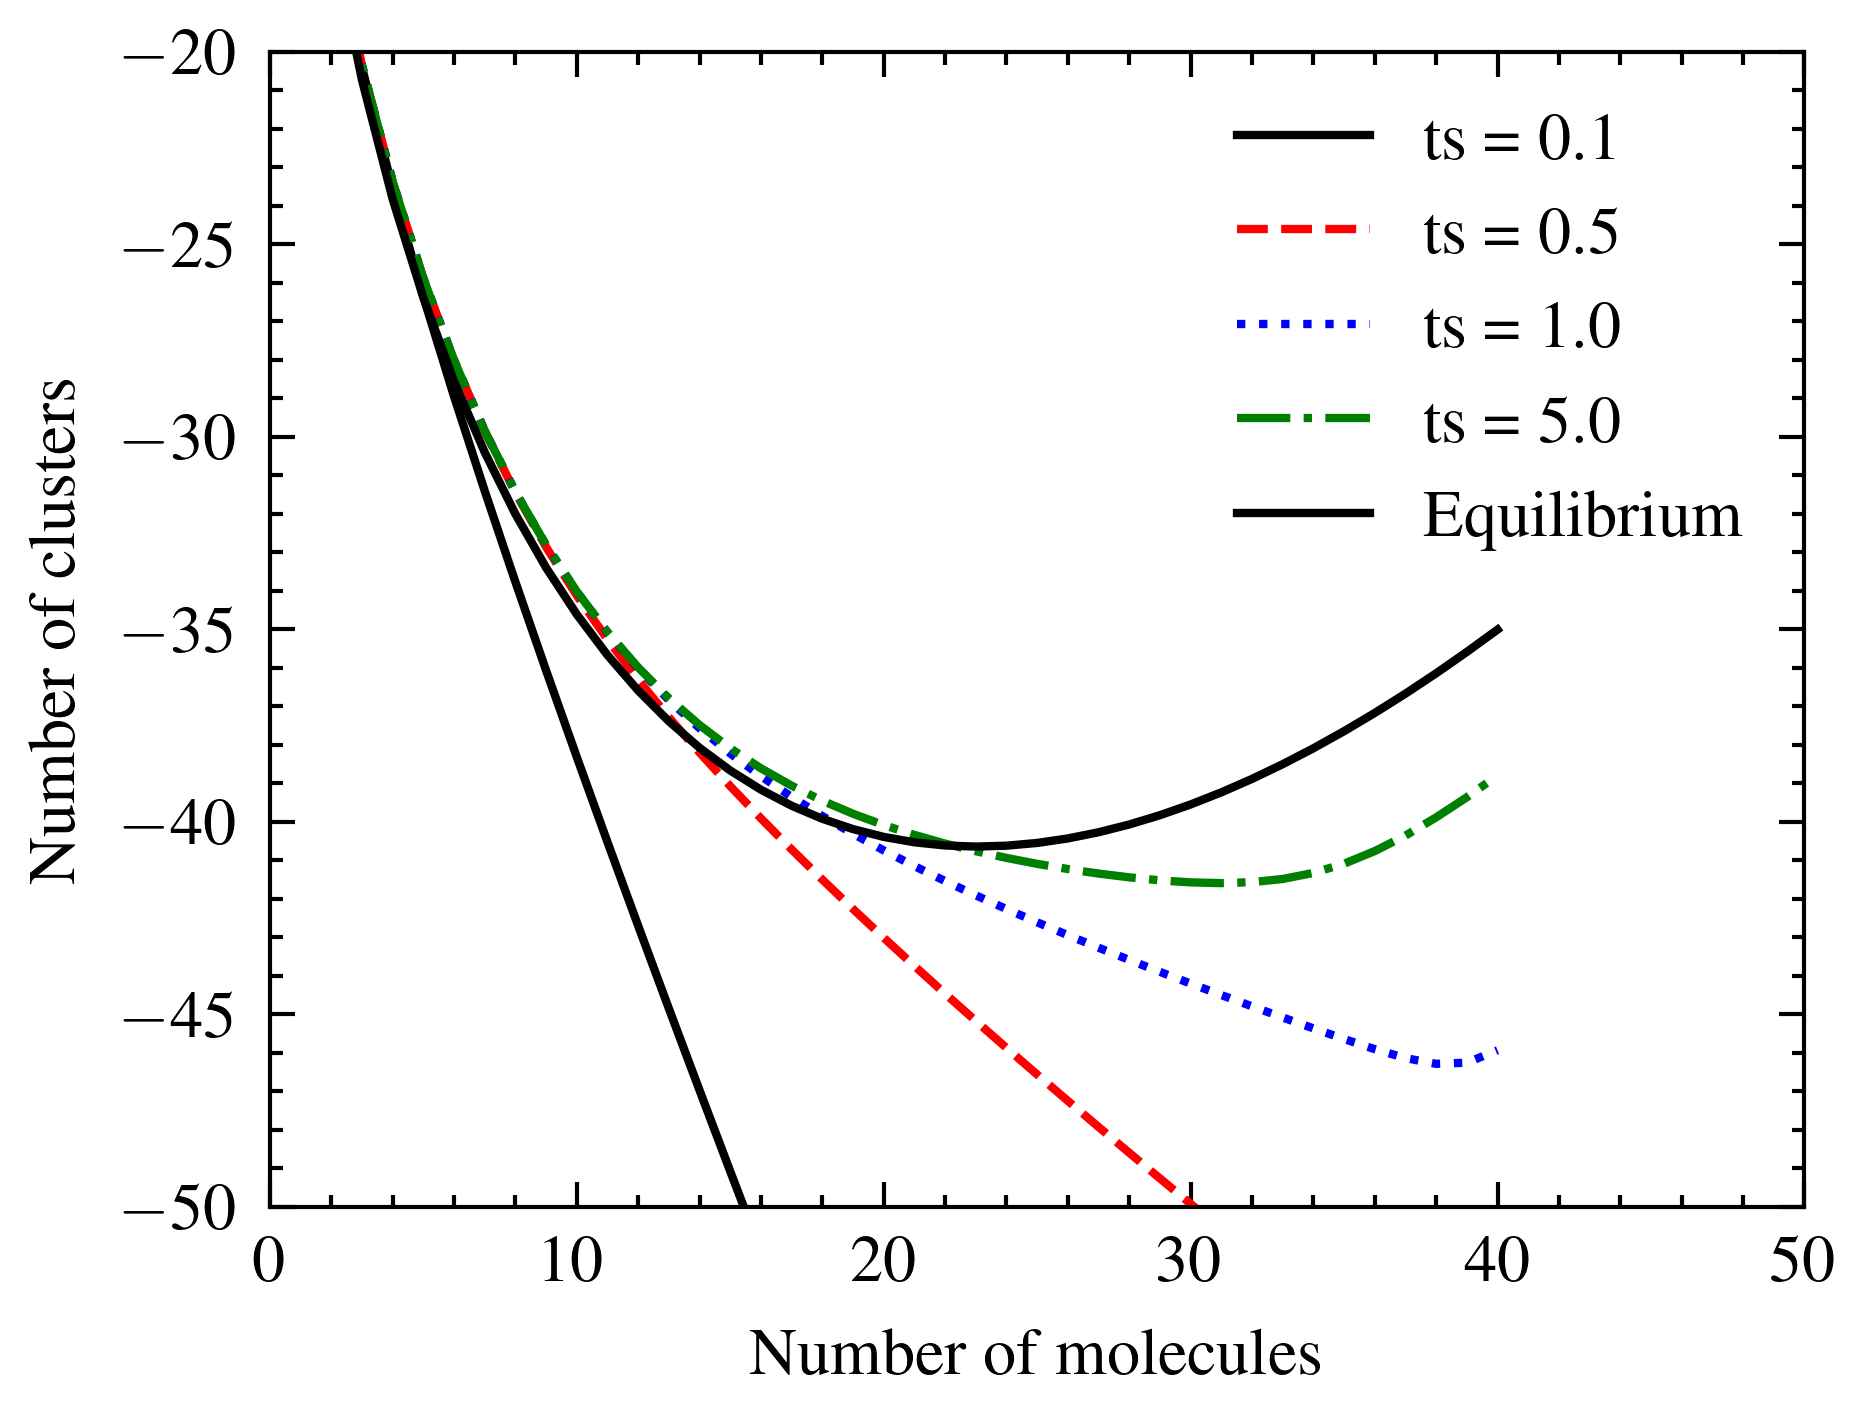

In [7]:
plt.figure()
n = np.linspace(1,40,40)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],np.log(y_array[i]/cluster_physics.AVOGADRO.magnitude), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
plt.plot(n,np.log(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,50)
plt.ylim(-50,-20)


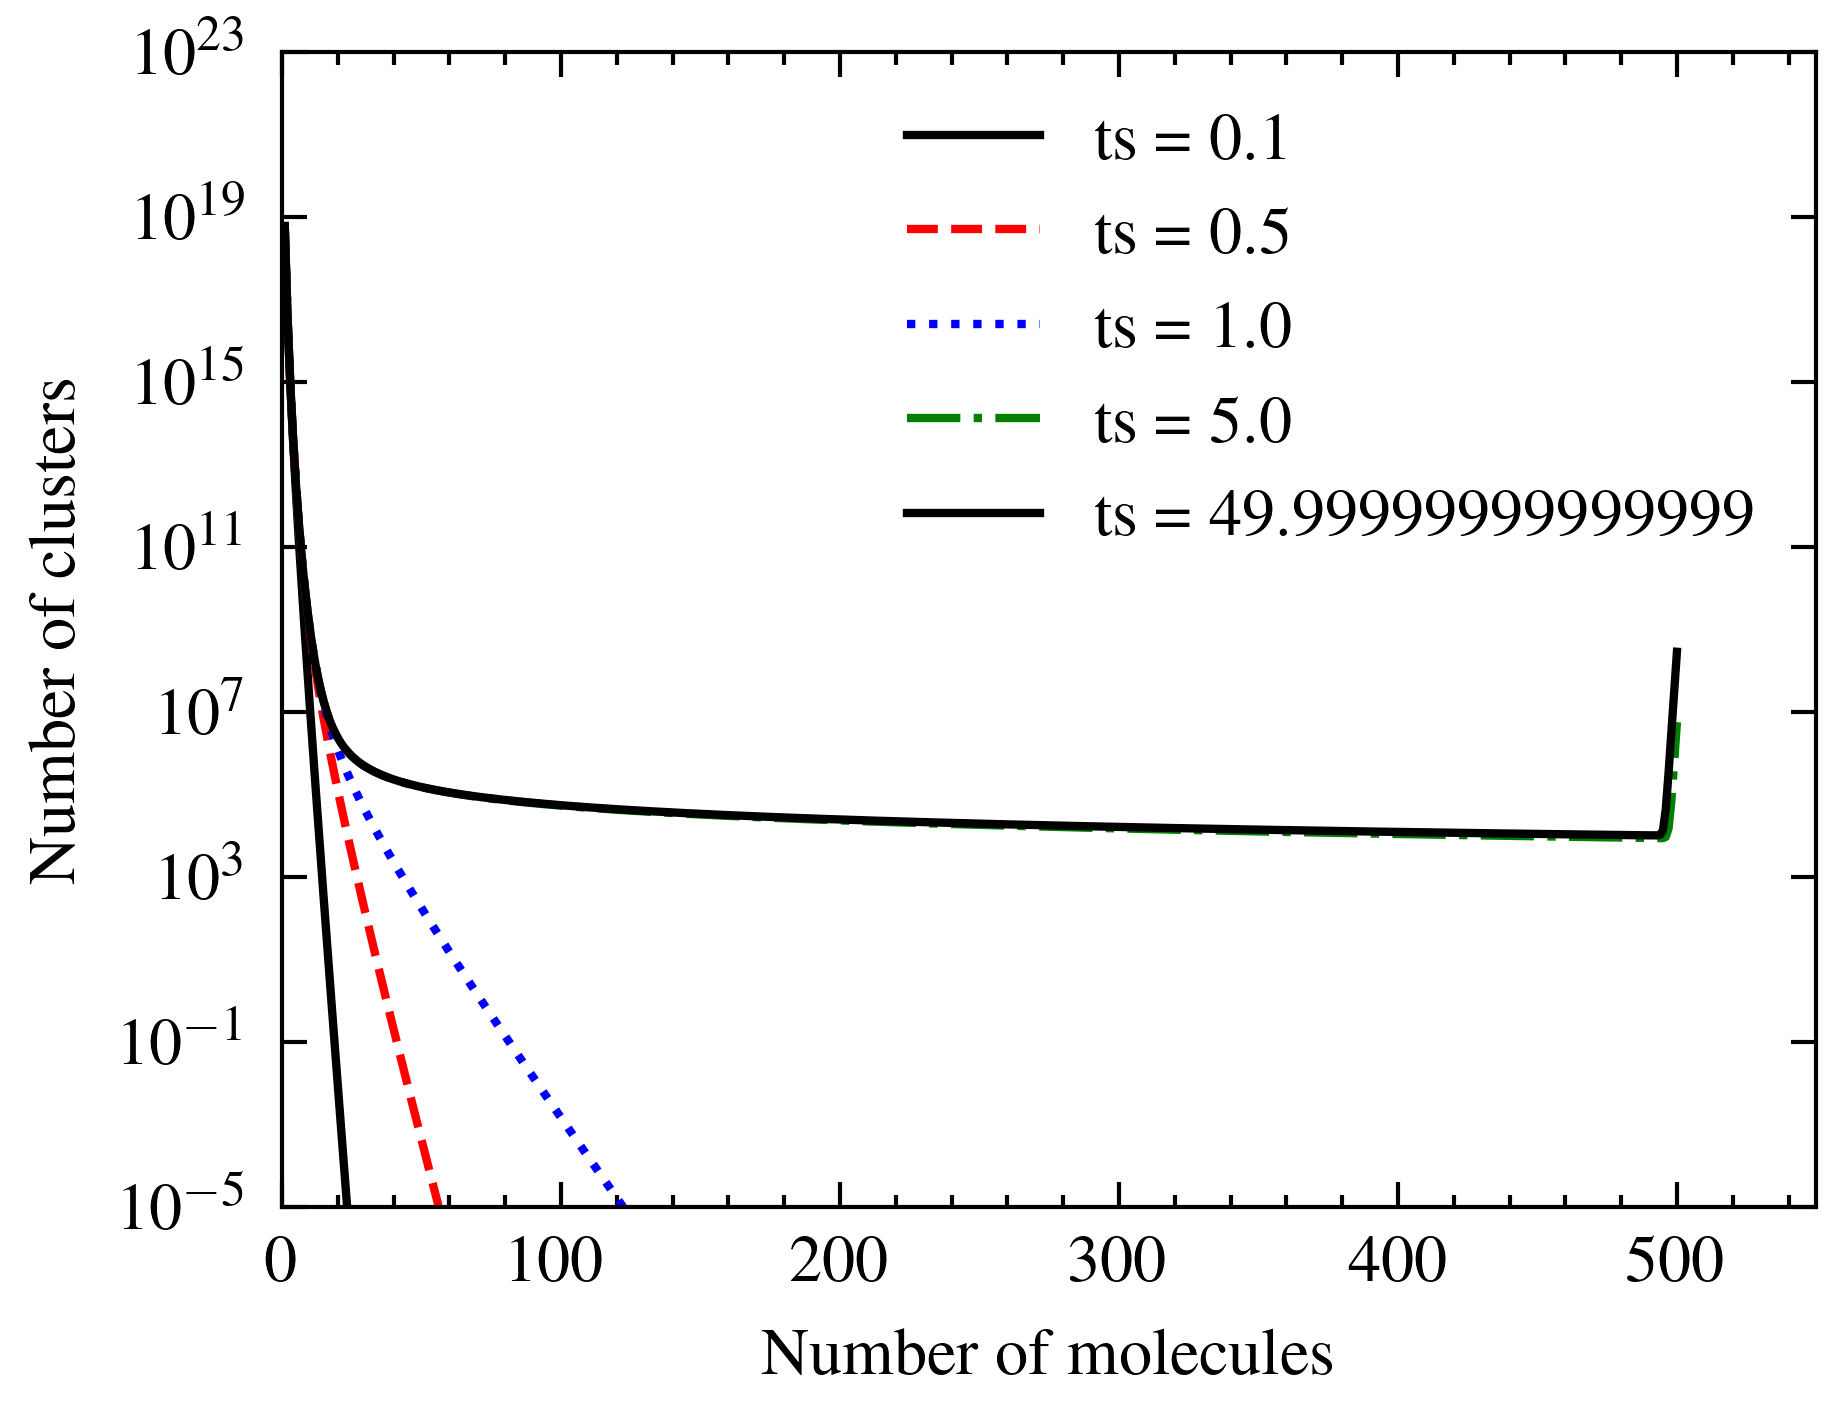

In [23]:
plt.figure()
n = np.linspace(1,500,500)
for i in range(len(time_step_array)):
    plt.plot(x_array[i],(y_array[i]), label = 'ts = '+str(time_step_array[i]*dt*cluster_physics.unbiased_jump_rate.magnitude))
#plt.plot(n,(cluster_physics.number_density_equilibrium(n).magnitude/cluster_physics.AVOGADRO.magnitude), label = 'Equilibrium')
plt.legend()
plt.xlabel('Number of molecules')
plt.ylabel('Number of clusters')
plt.xlim(0,550)
plt.ylim(1e-5,1e23)
plt.yscale('log')
